In [155]:
#ASTR 400B Homework 7
#Predict the future trajectory of M33 in the frame of M31
#Madison Walder

#People I collaborated with:
#Mackenzie James
#Ryan Webster
#Sean Cunningham
#Jimmy Lilly
#Steven Zhou-Wright

In [156]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass


In [157]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # 
        #Input: filename = name of file where you will store integrated orbit

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename = filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        self.M33COM = CenterOfMass("M33_000.txt", 2)
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        self.M33posvec = self.M33COM.COM_P(0.1,4.0)
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        self.M33velvec = self.M33COM.COM_V(self.M33posvec[0], self.M33posvec[1], self.M33posvec[2])
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        self.M31COM = CenterOfMass("M31_000.txt", 2)
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        self.M31posvec = self.M31COM.COM_P(0.1, 2.0)
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        self.M31velvec = self.M31COM.COM_V(self.M31posvec[0], self.M31posvec[1], self.M31posvec[2])
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them equal the
        # relative position and velocity VECTORS of M33
        self.relpos = np.subtract(self.M33posvec, self.M31posvec).value
        
        self.relvel = np.subtract(self.M33velvec, self.M31velvec).value
        #compute r0 and v0
        self.r0 = self.relpos
        self.v0 = self.relvel
        
        ### get the mass of each component in M31 
        ### disk
        self.rdisk = 5.0
        
        #set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass("M31_000.txt", 2)*1e12 
        
        
        ### bulge
        self.rbulge = 1.0
        
        #set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass("M31_000.txt", 3)*1e12  
        
        
        # Halo
        #set scale length from HW5 (no units)
        self.rhalo = 61.0 
        
        #set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass("M31_000.txt", 1)*1e12
 
    
    def HernquistAccel(self, M, r_a, pos): # it is easiest if you take as an input the position VECTOR 
        """ function that computes the gravitational acceleration vector induced by a Hernquist profile"""
        #Inputs:
            #M = total component mass
            #r_a = scale length
            #pos = position vector
        #Returns:
            #returns the acceleration vector for a given galaxy component
        ### **** Store the magnitude of the position vector
        rmag = np.linalg.norm(pos)
        
        ### *** Store the Acceleration
        Hern =  -pos*(self.G*M)/(rmag*(r_a + rmag)**2) 
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, rd, r):# it is easiest if you take as an input a position VECTOR  r 
        """ function that computes the gravitational acceleration vector for the disk using a 
            Miyamoto-Nagai 1975 profile"""
        #Inputs:
            #M = Mass of the disk
            #rd = self.rdisk
            #r = position vector
        #Returns:
            #returns the acceleration vector for a disk
        
        #calculate smaller parts
        zd = rd/5.0
        R = np.sqrt(r[0]**2 + r[1]**2)
        B = rd + np.sqrt(r[2]**2 + zd**2)

        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        
        MNAccel = -(self.G*M/(R**2 + B**2)**1.5) * np.multiply(r,np.array([1,1,B/np.sqrt(B-rd)]))
        
       
        return MNAccel 
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """function that sums all component acceleration vectors and returns the total 3D acceleration vector"""
        #Input:
            #r = 3D position vector
        #Returns:
            #total acceleration vector for all components of galaxy 
        
        M31bulgeaccel = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        M31haloaccel = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        M31diskaccel = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        
        M31bulgeandhaloaccel = np.add(M31bulgeaccel, M31haloaccel)
        M31totaccel = np.add(M31bulgeandhaloaccel, M31diskaccel)
            
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return M31totaccel
    
    
    
    def LeapFrog(self, dt,r,v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """function to integrate the motion of M33 over time"""
        #Inputs:
            #dt = user defined step forward in time
            #r = position vector
            #v = velocity vector
        #Returns:
            #new position and velocity vectors after a timestep 
        
        # predict the position at the next half timestep
        rhalf = r + v*(dt/2)
        
        # compute the velocity at the next timestep
        vnew = v + self.M31Accel(rhalf)*dt
        
        # compute the position at the next timestep
        rnew = r + 0.5*(v + vnew)*dt
        
        return rnew, vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """function that loops over the LeapFrog integrator to compute the orbit of M33 in the future"""
        #Inputs:
            #t0 = starting time of integration
            #dt = step forward in time
            #tmax = ending time of integration
        #Returns:
            #file of orbit

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros([int(tmax/dt)+2, 7])
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t = t + dt
            
           
            # **** store the new time in the first element of the ith row
            orbit[i, 0] = t
            #print(orbit[i,0])
            
            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            rnew, vnew = self.LeapFrog(dt, orbit[i-1,1:4], orbit[i-1,4:7]) 
         
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            orbit[i, 1:4] = rnew
            orbit[i, 4:7] = vnew
            
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i = i + 1
            #print(i)
        
        # write the data to a file
        np.savetxt(self.filename, orbit[:-1], fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function

In [158]:
#create an instance of the M33Analytic Orbit class
M33AOrbit = M33AnalyticOrbit("M33FutureOrbit.txt")

In [159]:
#integrate the orbit
M33AOrbit.OrbitIntegration(0, 0.1, 10.0)

In [160]:
#function that computes the difference between 2 vectors and returns the magnitude of the 
#resulting vector (from OrbitCOM)
def VecDiff(vec1, vec2):
    #Inputs:
        #vec1 = 1st input vector (array)
        #vec2 = 2nd input vector (array)
    #Results:
        #magnitude of vector difference
        
    #subtract the input vectors from each other
    vecdiff = np.subtract(vec1, vec2)
    
    #calculate the magnitude of the difference vector, found a neat function of numpy to do it!
    magnitude = np.linalg.norm(vecdiff)
    
    return magnitude

In [161]:
#read in data from file just created
M33analysisdata = np.genfromtxt("M33FutureOrbit.txt", dtype = None, names = True, comments = '#')

M33atime = M33analysisdata['t']
M33ax = M33analysisdata['x']
M33ay = M33analysisdata['y']
M33az = M33analysisdata['z']
M33avx = M33analysisdata['vx']
M33avy = M33analysisdata['vy']
M33avz = M33analysisdata['vz']

#read in data from older simulation files
M31data = np.genfromtxt("Orbit_M31.txt", dtype = None, names = True, comments = '#')
M33data = np.genfromtxt("Orbit_M33.txt", dtype = None, names = True, comments = '#')

#create arrays of separate data for each galaxy (i.e. each parameter gets its own array)
#for M31
M31time = M31data['t']
M31x = M31data['x']
M31y = M31data['y']
M31z = M31data['z']
M31vx = M31data['vx']
M31vy = M31data['vy']
M31vz = M31data['vz']

#for M33
M33time = M33data['t']
M33x = M33data['x']
M33y = M33data['y']
M33z = M33data['z']
M33vx = M33data['vx']
M33vy = M33data['vy']
M33vz = M33data['vz']

In [162]:
#recreate an array of COM position and velocity vectors for each galaxy by using np.column_stack
M31COMP = np.column_stack((M31x, M31y, M31z))
M31COMV = np.column_stack((M31vx, M31vy, M31vz))
M33COMP = np.column_stack((M33x, M33y, M33z))
M33COMV = np.column_stack((M33vx, M33vy, M33vz))

Text(0.5,1,'Separation of M33 and M31 over Time')

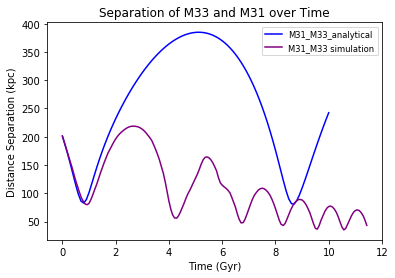

In [163]:
#calculate position and velocity of M33 relative to M31 for the analytic orbit
M33rmag = np.sqrt(M33ax**2 + M33ay**2 + M33az**2)
M33vmag = np.sqrt(M33avx**2 + M33avy**2 + M33avz**2)

#loop through array of COMP and COMV vectors and use VecDiff function to to compute 
#magnitude of separation in distance and velocity of M33 and M31

#initialize arrays to store magnitude of differences in distance and velocity for the M33 and M31
MagDistdiff2 = np.zeros(len(M31COMP))
MagVeldiff2 = np.zeros(len(M31COMV))

#loop over each array and store the vector differences for both distance 
for i in range(len(M31COMP)):
    MagDistdiff2[i] = VecDiff(M31COMP[i], M33COMP[i])
    MagVeldiff2[i] = VecDiff(M31COMV[i], M33COMV[i])
                     
#plot the magnitude of separation between M33 and M31 as a function of time for both the analytical and simulation orbit
plt.plot(M33atime, M33rmag, color = "blue", label = "M31_M33_analytical")
plt.plot(M33time, MagDistdiff2, color = "purple", label = "M31_M33 simulation")
plt.plot()
plt.legend(fontsize = "small")
plt.xlabel("Time (Gyr)")
plt.ylabel("Distance Separation (kpc)")
plt.title("Separation of M33 and M31 over Time")

Text(0.5,1,'Relative Velocity of M33 and M31 over Time')

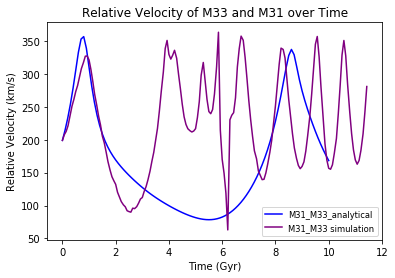

In [164]:
#plot the relative velocity of M33 with respect to M31 as a function of time for both the analytical and simulation orbit
plt.plot(M33atime, M33vmag, color = "blue", label = "M31_M33_analytical")
plt.plot(M33time, MagVeldiff2, color = "purple", label = "M31_M33 simulation")
plt.legend(fontsize = "small")
plt.xlabel("Time (Gyr)")
plt.ylabel("Relative Velocity (km/s)")
plt.title("Relative Velocity of M33 and M31 over Time")

# How do the plots compare?
For the separation between M33 and M31, the simulation data shows many more "close encounters" between M33 and M31 between 0-10 Gyr where the analytical data shows one close encounter a ~1 Gyr and then another at ~9 Gyr in the future.  For the relative velocity of M33 with respect to M31, it is the same situation as with the separation over time graph where whenever there is a close encounter the relative velocity peaks so there are many more peaks for the simulated data than for the analytical data. 

# What missing physics could make the difference?
The fact that the Milky Way merges with Andromeda at ~6.5 Gyr is missing which definitely affects how the orbit of M33 looks over time.  The analytical data only takes into account what the orbit of M33 would like for just the M33 and M31 system, whereas the simulation accounts for the MW, M31, and M33.  Thus, adding another body to the system can significantly alter the gravitational effects on M33 in its orbit.   

# The Milky Way is missing in these calculations. How might you include its effects?
You could include its effects by recalculating the acceleration on M33 to have it include the gravitational effects of the MW on it as well as M31 once the Milky Way's gravity becomes much more significant to the point where it could alter M33's orbit (i.e. when the Milky Way and Andromeda are closer together).  You could also recalculate the acceleration due to gravity on M33 after M31 and the MW have merged by recalculating the COM of the M31 and MW system. 